In [1]:
#Libraries Required
import os

import numpy as np  
import pandas as pd 

pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
import seaborn as sns
 
import datetime
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval, STATUS_RUNNING

## Data Pre-processing

In [2]:
folder = './data/'

train = pd.read_csv(os.path.join(folder, 'Train_Dataset.csv'))
test = pd.read_csv(os.path.join(folder, 'Test_Dataset.csv'))

In [4]:
# checking the difference between train and test dataset columns
# Only target column is missing which is expected
set(train.columns).difference(set(test.columns))

{'Default'}

In [49]:
def summary_table(df):
    
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    return summary

## missing data
def missing_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_cols = missing_data[missing_data['Total']>0]
    print(f"Your Dataframe has {df.shape[1]} columns, out of which {missing_cols.shape[0]}")
    missing_data.head(20).style.background_gradient(cmap='Greens') #'Reds'
    return missing_data

In [9]:
summary_table(train)

Dataset Shape: (121856, 40)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,ID,int64,0,121856,12142509,12138936,12181264
1,Client_Income,object,3607,1516,6750,20250,18000
2,Car_Owned,float64,3581,2,0.0,1.0,0.0
3,Bike_Owned,float64,3624,2,0.0,0.0,0.0
4,Active_Loan,float64,3635,2,1.0,1.0,1.0
5,House_Own,float64,3661,2,0.0,NaN,0.0
6,Child_Count,float64,3638,14,0.0,0.0,1.0
7,Credit_Amount,object,3632,6816,61190.55,15282,59527.35
8,Loan_Annuity,object,4812,16680,3416.85,1826.55,2788.2
9,Accompany_Client,object,1746,7,Alone,Alone,Alone


In [3]:
float_cols_to_fix = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Employed_Days', 'Age_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age', 'Score_Source_3']
string_cols_to_fix = ['Accompany_Client']
XNA_cols_to_fix = ['Client_Gender', 'Type_Organization']

def data_preprocess(df):
    
    # Create a regular expression pattern to match non-floating-point numbers
    pattern = re.compile(r'^[-+]?\d+(\.\d+)?$')

    for col in float_cols_to_fix:
        # Use np.where to replace non-floating-point numbers with np.nan
        df[col] = np.where(df[col].astype(str).str.match(pattern), df[col], np.nan)
        df[col] = df[col].astype('float')
         
    for col in string_cols_to_fix:
        # Use np.where to replace non-string values with np.nan
        df[col] = np.where(df[col]== '##', np.nan, df[col])
        
    for col in XNA_cols_to_fix:
        # Use np.where to replace non-string values with np.nan
        df[col] = np.where(df[col]== 'XNA', np.nan, df[col])
        
    return df

In [4]:
train = data_preprocess(train)
train.columns = train.columns.str.replace('Cleint', 'Client') #spelling

In [38]:
test = data_preprocess(test)
test.columns = test.columns.str.replace('Cleint', 'Client') #spelling

In [96]:
## missing data
missing_values(train)

Your Dataframe has 40 columns, out of which 33


,Total,Percent
Own_House_Age,80095,0.657292
Score_Source_1,68835,0.564888
Social_Circle_Default,61928,0.508206
Client_Occupation,41435,0.340032
Score_Source_3,26922,0.220933
Type_Organization,24694,0.202649
Credit_Bureau,18540,0.152147
ID_Days,5985,0.049115
Score_Source_2,5686,0.046662
Population_Region_Relative,4868,0.039949


**Key Inference**

- Own_House_Age, Score_Source_1, and Social_Circle_Default have > 50% missing values.

In [6]:
cat_cols = [c for c in train.columns if train[c].dtypes=='O']
num_cols = [c for c in train.columns if train[c].dtypes!='O']

# control check
assert len(cat_cols)+len(num_cols) == len(train.columns)

In [53]:
# train.to_parquet('./data/processed/training_data_non_encoded.parquet', index=False)

# Exploratory Data Analysis

In [8]:
train.describe()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
count,1.218560e+05,1.182340e+05,118275.000000,118232.000000,118221.000000,118195.000000,118218.000000,118219.000000,117030.000000,116988.000000,118239.000000,118190.000000,118225.000000,115871.000000,41761.000000,121856.000000,121856.000000,121856.000000,119446.000000,119447.000000,119428.000000,118193.000000,53021.000000,116170.000000,94934.000000,59928.000000,118192.000000,103316.000000,121856.000000
mean,1.216093e+07,1.686519e+04,0.342854,0.332262,0.499175,0.692060,0.417779,60046.488951,2721.254492,0.022602,16027.422948,67154.070615,4975.162123,2987.471015,12.157324,0.999992,0.200499,0.281201,2.154329,2.030038,3.159736,12.063100,0.501213,0.518625,0.511180,0.117428,962.106056,1.891082,0.080792
std,3.517694e+04,1.153815e+04,0.474665,0.471026,0.500001,0.461644,0.728802,40350.663346,1461.466162,0.413617,4366.356504,138971.782951,3514.546963,1511.884576,12.056079,0.002865,0.400375,0.449587,0.912686,0.504407,1.759045,3.280695,0.211204,0.740248,0.194333,0.107974,827.976726,1.861921,0.272517
min,1.210000e+07,2.565000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,217.350000,0.000533,7676.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.014568,0.000005,0.000527,0.000000,0.000000,0.000000,0.000000
25%,1.213046e+07,1.125000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,27000.000000,1657.350000,0.010006,12398.000000,932.000000,2008.000000,1705.000000,5.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.333481,0.390164,0.372334,0.057700,272.000000,0.000000,0.000000
50%,1.216093e+07,1.440000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,51750.000000,2499.750000,0.018850,15734.000000,2212.000000,4493.000000,3242.000000,9.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,12.000000,0.504657,0.564978,0.537070,0.088700,755.000000,1.000000,0.000000
75%,1.219139e+07,2.025000e+04,1.000000,1.000000,1.000000,1.000000,1.000000,80865.000000,3466.800000,0.028663,19661.000000,5634.000000,7464.000000,4295.000000,15.000000,1.000000,0.000000,1.000000,3.000000,2.000000,5.000000,14.000000,0.673890,0.664011,0.667458,0.148500,1570.000000,3.000000,0.000000
max,1.222186e+07,1.800009e+06,1.000000,1.000000,1.000000,1.000000,19.000000,405000.000000,22500.000000,100.000000,25201.000000,365243.000000,23738.000000,7197.000000,69.000000,1.000000,1.000000,1.000000,16.000000,3.000000,6.000000,23.000000,0.945741,100.000000,0.896010,1.000000,4185.000000,22.000000,1.000000


## Loan Disbursement Analsyis

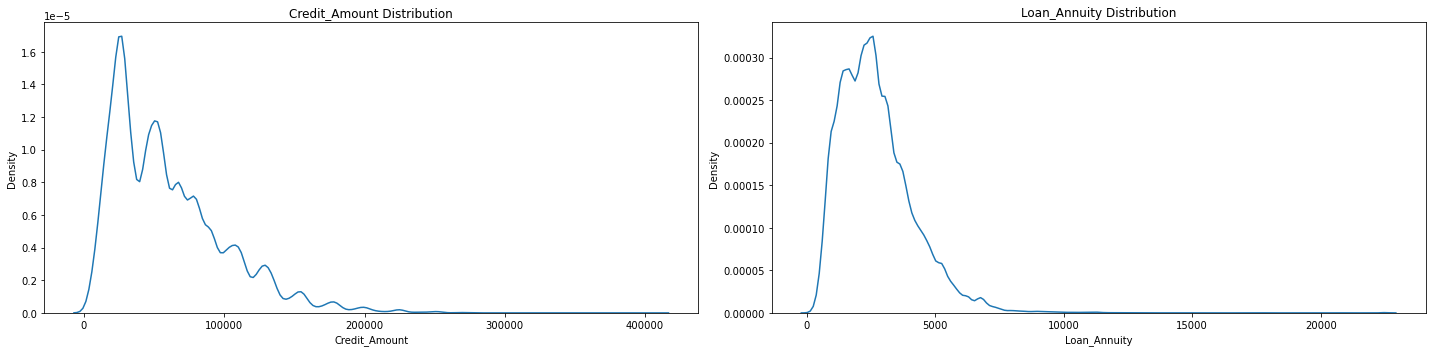

In [39]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.kdeplot(x=train["Credit_Amount"], ax=ax[0])
ax[0].set_title('Credit_Amount Distribution')

# Plot on the second subplot
sns.kdeplot(x=train["Loan_Annuity"], ax=ax[1])
ax[1].set_title('Loan_Annuity Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [42]:
#skewness and kurtosis
print('Credit_Amount skewness and kurtosis')
print("Skewness: %f" % train["Credit_Amount"].skew())
print("Kurtosis: %f" % train["Credit_Amount"].kurt())

print('\nLoan_Annuity skewness and kurtosis')
print("Skewness: %f" % train["Loan_Annuity"].skew())
print("Kurtosis: %f" % train["Loan_Annuity"].kurt())

Credit_Amount skewness and kurtosis
Skewness: 1.230314
Kurtosis: 1.886005

Loan_Annuity skewness and kurtosis
Skewness: 1.680135
Kurtosis: 9.031345


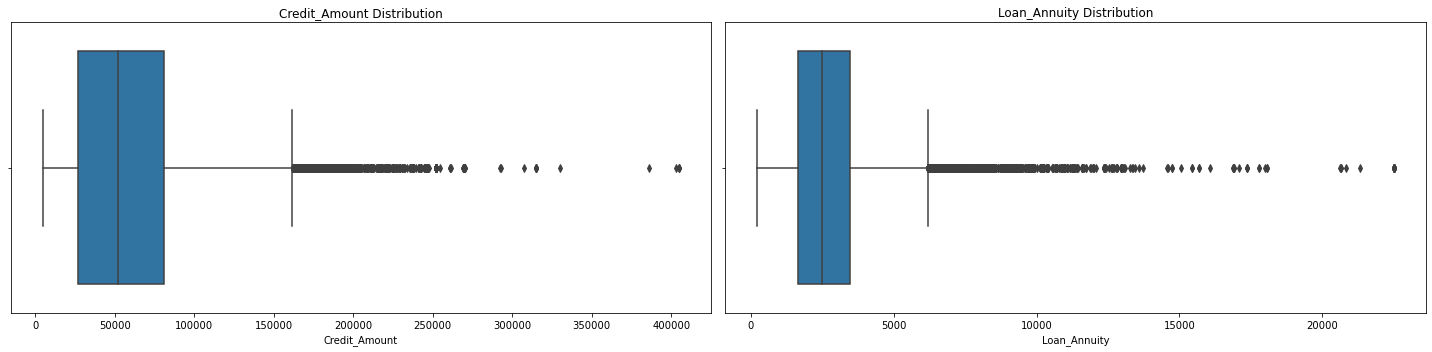

In [38]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.boxplot(x=train["Credit_Amount"], ax=ax[0])
ax[0].set_title('Credit_Amount Distribution')

# Plot on the second subplot
sns.boxplot(x=train["Loan_Annuity"], ax=ax[1])
ax[1].set_title('Loan_Annuity Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [25]:
ca = np.array(train["Credit_Amount"])
print("Credit_Amount Values bigger than 2500000 =", len(ca[ca>250000]))

la = np.array(train["Loan_Annuity"])
print("Loan_Annuity Values bigger than 1500000 =", len(la[la>15000]))

Credit_Amount Values bigger than 2500000 = 122
Loan_Annuity Values bigger than 1500000 = 38


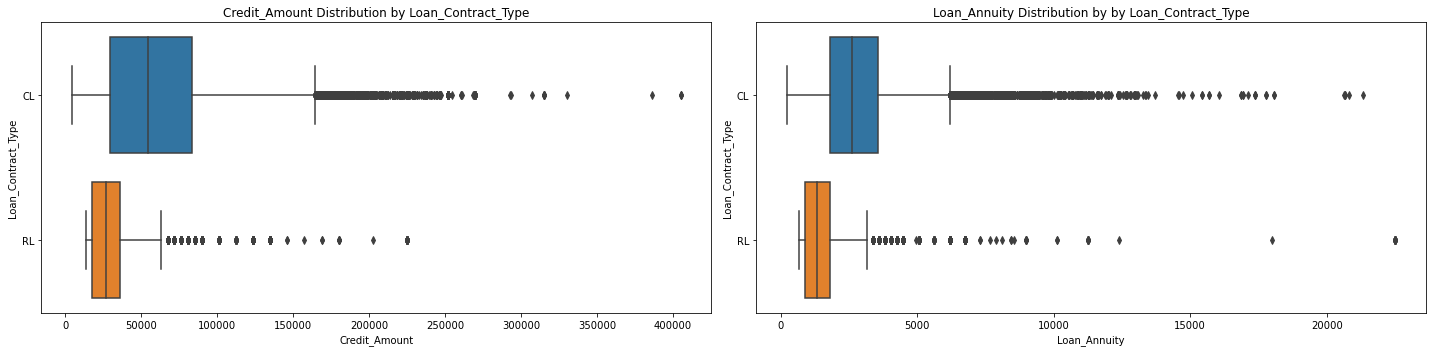

In [56]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.boxplot(x=train["Credit_Amount"], y=train["Loan_Contract_Type"], ax=ax[0])
ax[0].set_title('Credit_Amount Distribution by Loan_Contract_Type')

# Plot on the second subplot
sns.boxplot(x=train["Loan_Annuity"], y=train["Loan_Contract_Type"], ax=ax[1])
ax[1].set_title('Loan_Annuity Distribution by by Loan_Contract_Type')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

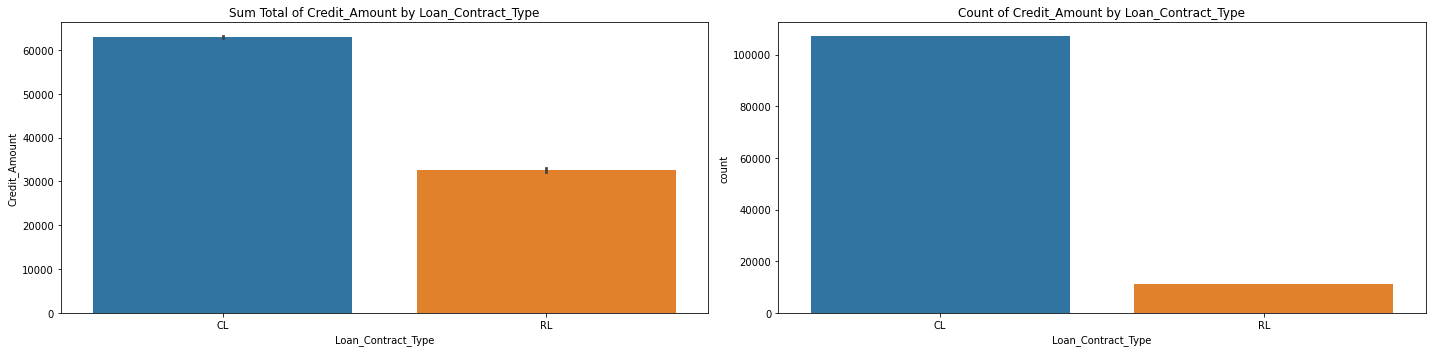

In [71]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.barplot(data=train, x="Loan_Contract_Type", y="Credit_Amount", ax=ax[0])
ax[0].set_title('Sum Total of Credit_Amount by Loan_Contract_Type')

# Plot on the second subplot
sns.countplot(data=train, x="Loan_Contract_Type", ax=ax[1])
ax[1].set_title('Count of Credit_Amount by Loan_Contract_Type')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

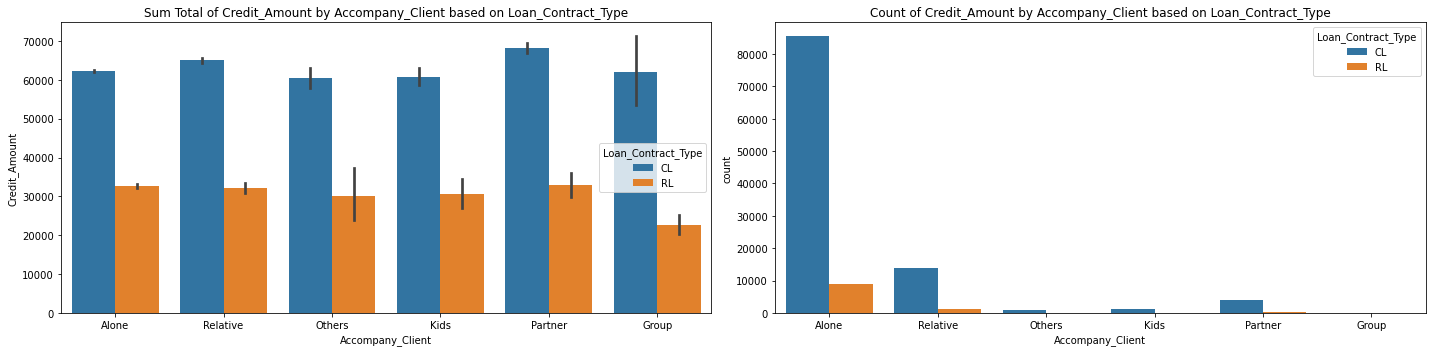

In [81]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.barplot(data=train, x="Accompany_Client", y="Credit_Amount", hue="Loan_Contract_Type", ax=ax[0])
ax[0].set_title('Sum Total of Credit_Amount by Accompany_Client based on Loan_Contract_Type')

# Plot on the second subplot
sns.countplot(data=train, x="Accompany_Client", hue="Loan_Contract_Type", ax=ax[1])
ax[1].set_title('Count of Credit_Amount by Accompany_Client based on Loan_Contract_Type')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

**Key Inference**

- Both Credit_Amount & Loan_Annuity are Positively Skewed
- Both Credit_Amount & Loan_Annuity have some large values of Credit and annuity given to clients.
- More Cash Loans were given than Revolving Loan
- Clients prefer to come along with SOMEONE rather than coming ALONE.

## Background Verification Analysis

### Client Income and Credit Amount Analysis

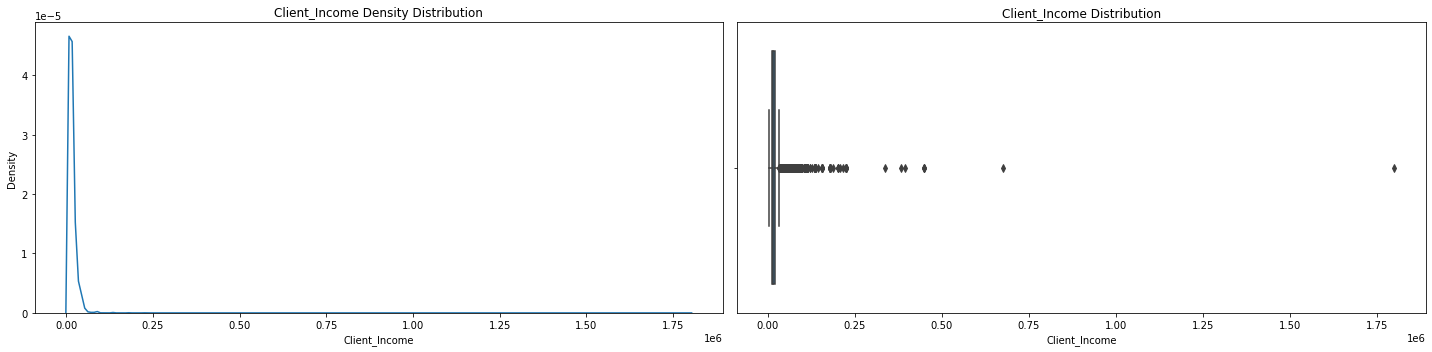

In [82]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.kdeplot(x=train["Client_Income"], ax=ax[0])
ax[0].set_title('Client_Income Density Distribution')

# Plot on the second subplot
sns.boxplot(x=train["Client_Income"], ax=ax[1])
ax[1].set_title('Client_Income Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

**Key Inference**

- 75% of clients have income <20k, this indicates that the loan is given to people with low income groups. They have generally high chance of default. 

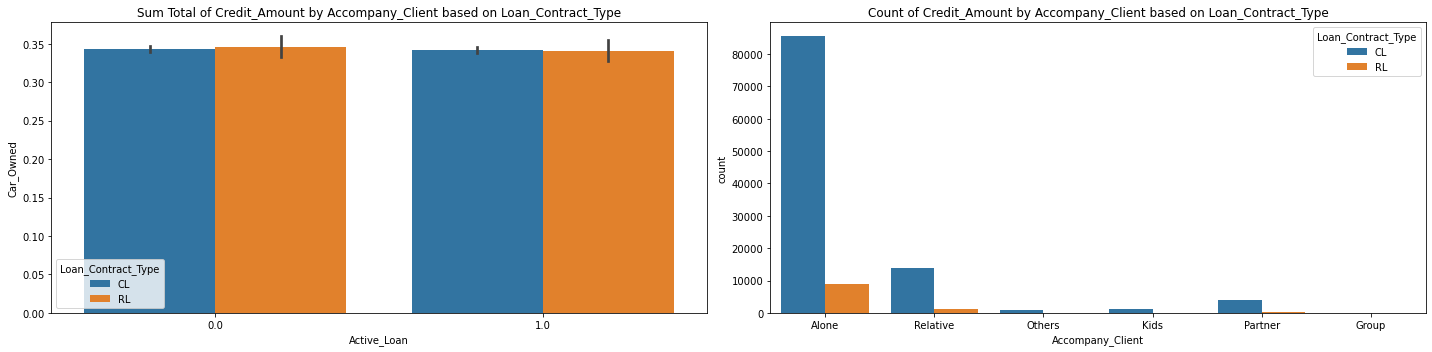

In [153]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Plot on the first subplot
sns.barplot(data=train, x="Active_Loan", y="Car_Owned", hue="Loan_Contract_Type", ax=ax[0])
ax[0].set_title('Sum Total of Credit_Amount by Accompany_Client based on Loan_Contract_Type')

# Plot on the second subplot
sns.countplot(data=train, x="Accompany_Client", hue="Loan_Contract_Type", ax=ax[1])
ax[1].set_title('Count of Credit_Amount by Accompany_Client based on Loan_Contract_Type')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [154]:
train.groupby("Client_Income_Type", as_index=False)['Credit_Amount'].count().sort_values('Credit_Amount', ascending=False)

,Client_Income_Type,Credit_Amount
5,Service,59248
1,Commercial,26948
4,Retired,20390
2,Govt Job,8027
6,Student,7
7,Unemployed,6
3,Maternity leave,2
0,Businessman,1


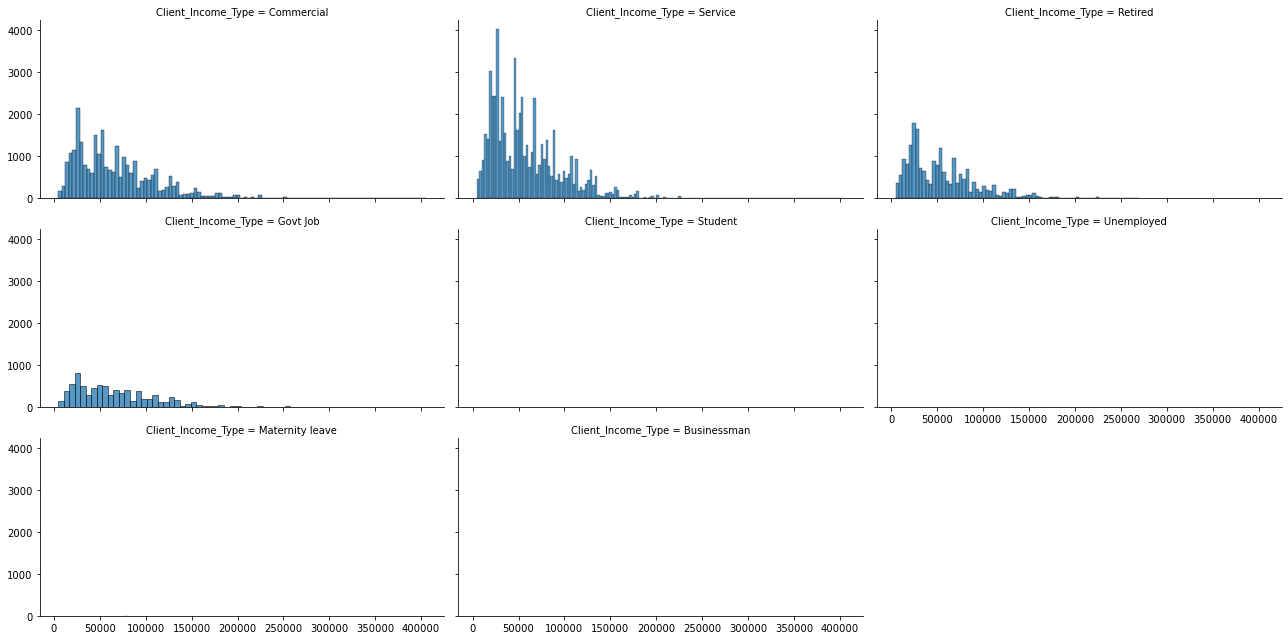

In [112]:
g = sns.FacetGrid(train, col="Client_Income_Type", size=3.5, aspect=2, col_wrap=3)
g.map_dataframe(sns.histplot, x="Credit_Amount")

g.fig.subplots_adjust(top=0.85) # adjust the Figure in g
g.fig.suptitle('Credit_Amount Disbursement across Client_Income_Type', fontsize=16)

In [151]:
train.groupby("Client_Education", as_index=False)['Credit_Amount'].count().sort_values('Credit_Amount', ascending=False)

,Client_Education,Credit_Amount
4,Secondary,81421
0,Graduation,27942
1,Graduation dropout,3828
2,Junior secondary,1411
3,Post Grad,64


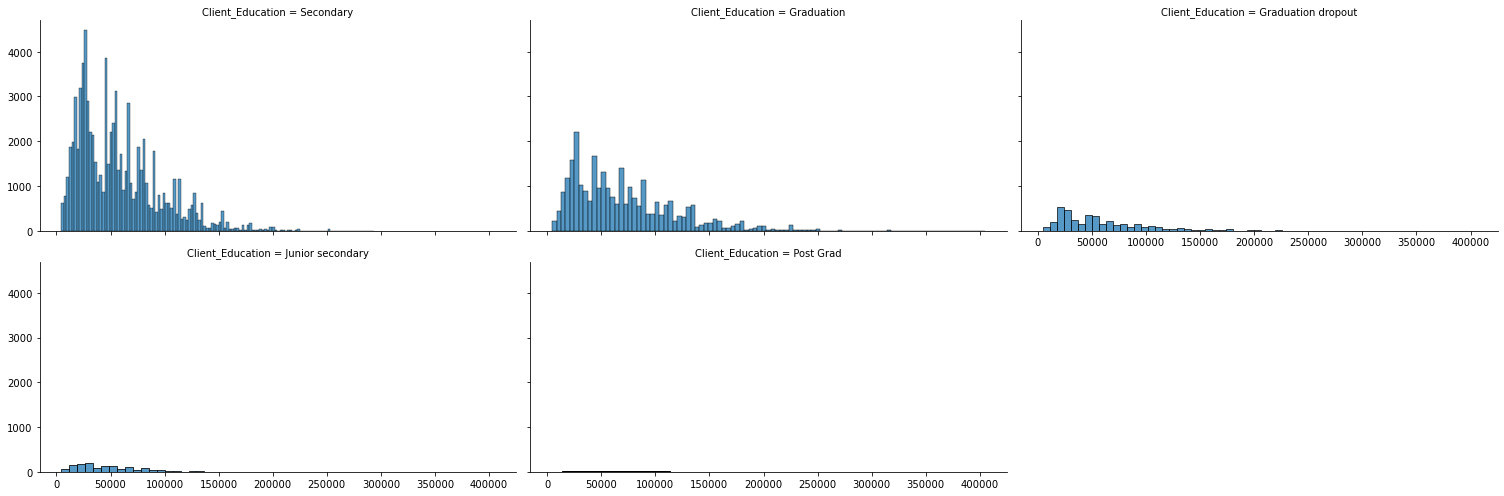

In [113]:
g = sns.FacetGrid(train, col="Client_Education", size=3.5, aspect=2, col_wrap=3)
g.map_dataframe(sns.histplot, x="Credit_Amount")

g.fig.subplots_adjust(top=0.85) # adjust the Figure in g
g.fig.suptitle('Credit_Amount Disbursement across Client_Education', fontsize=16)

**Key Inference**

- Mostly client's are from Service, Commercial and Retired income types. Negilible Credit Volumnes were given to Students, Unemployed, ML and businessman. 
- Mostly client's education is Secondary, Graduation. Very few are post graduates.
- Hence, we can draw an inference that this loan disbursal mechanishm is ONLY for low income groups.

In [150]:
train.groupby(["Client_Gender", "Client_Marital_Status"])['Credit_Amount'].count().unstack()

Client_Marital_Status,D,M,S,W
Client_Gender,,,,
Female,1546,30557,6186,312
Male,5648,52510,10375,5451


<Figure size 360x1080 with 0 Axes>

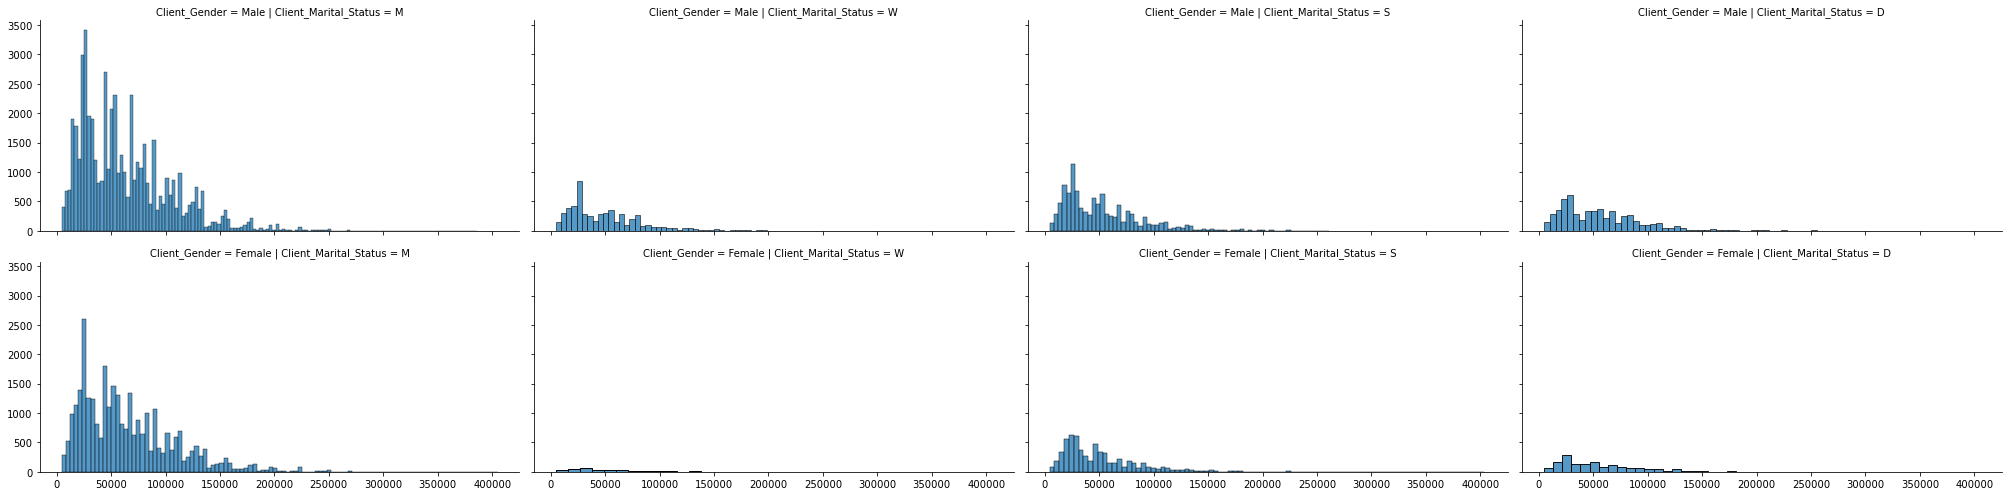

In [115]:
plt.figure(figsize=(5,15))

g = sns.FacetGrid(train, col="Client_Marital_Status", row="Client_Gender", size=3.5, aspect=2)
g.map_dataframe(sns.histplot, x="Credit_Amount")

g.fig.subplots_adjust(top=0.85) # adjust the Figure in g
g.fig.suptitle('Credit_Amount Disbursement across Client Gender and Marital_Status', fontsize=16)

- Married Males and Females are taking the most credit loan, followed by Single Males and Females.
- Divorced and Widowed have the lowest loan disbural.

Text(0.5, 0.98, 'Credit_Amount Disbursement across Client_Housing_Type')

<Figure size 360x1080 with 0 Axes>

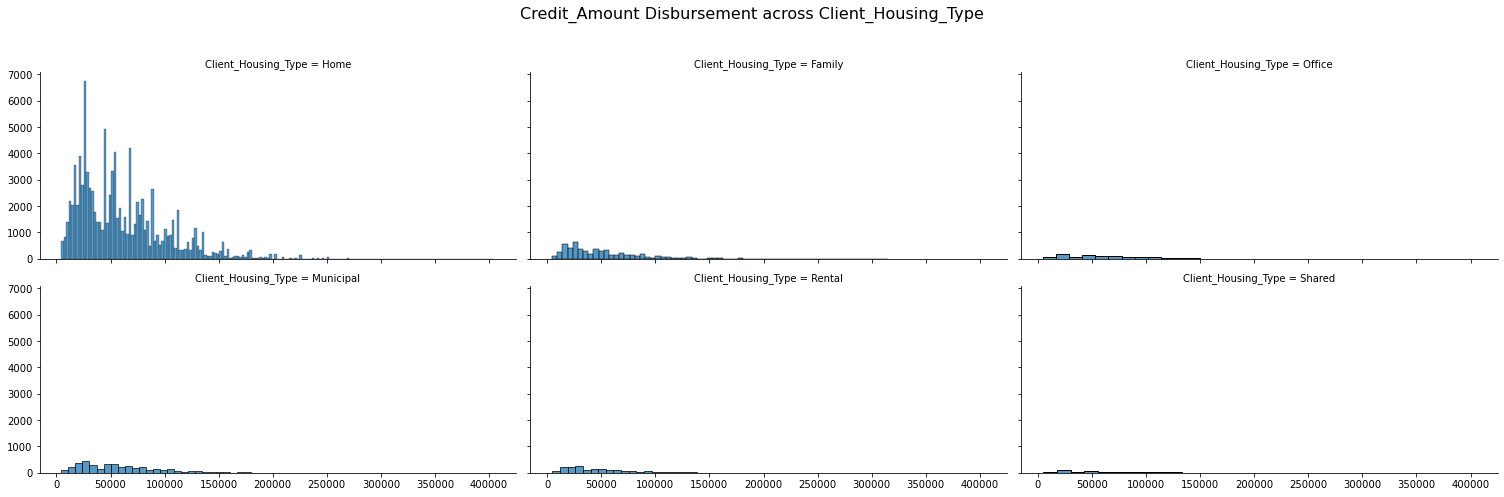

In [129]:
plt.figure(figsize=(5,15))

g = sns.FacetGrid(train, col="Client_Housing_Type", size=3.5, aspect=2, col_wrap=3)
g.map_dataframe(sns.histplot, x="Credit_Amount")

g.fig.subplots_adjust(top=0.85) # adjust the Figure in g
g.fig.suptitle('Credit_Amount Disbursement across Client_Housing_Type', fontsize=16)

In [144]:
train.groupby("Client_Housing_Type", as_index=False)['Credit_Amount'].count().sort_values('Credit_Amount', ascending=False)

,Client_Housing_Type,Credit_Amount
1,Home,101771
0,Family,5598
2,Municipal,4107
4,Rental,1758
3,Office,973
5,Shared,433


**Key Inference**

- Most of the Credit_Amount was disbursed to the clients who have their own HOME.
- Family houses, rentals and office has low loan disbural rate.

Text(0.5, 0.98, 'Credit_Amount Disbursement across Client_Occupation_Type')

<Figure size 360x1080 with 0 Axes>

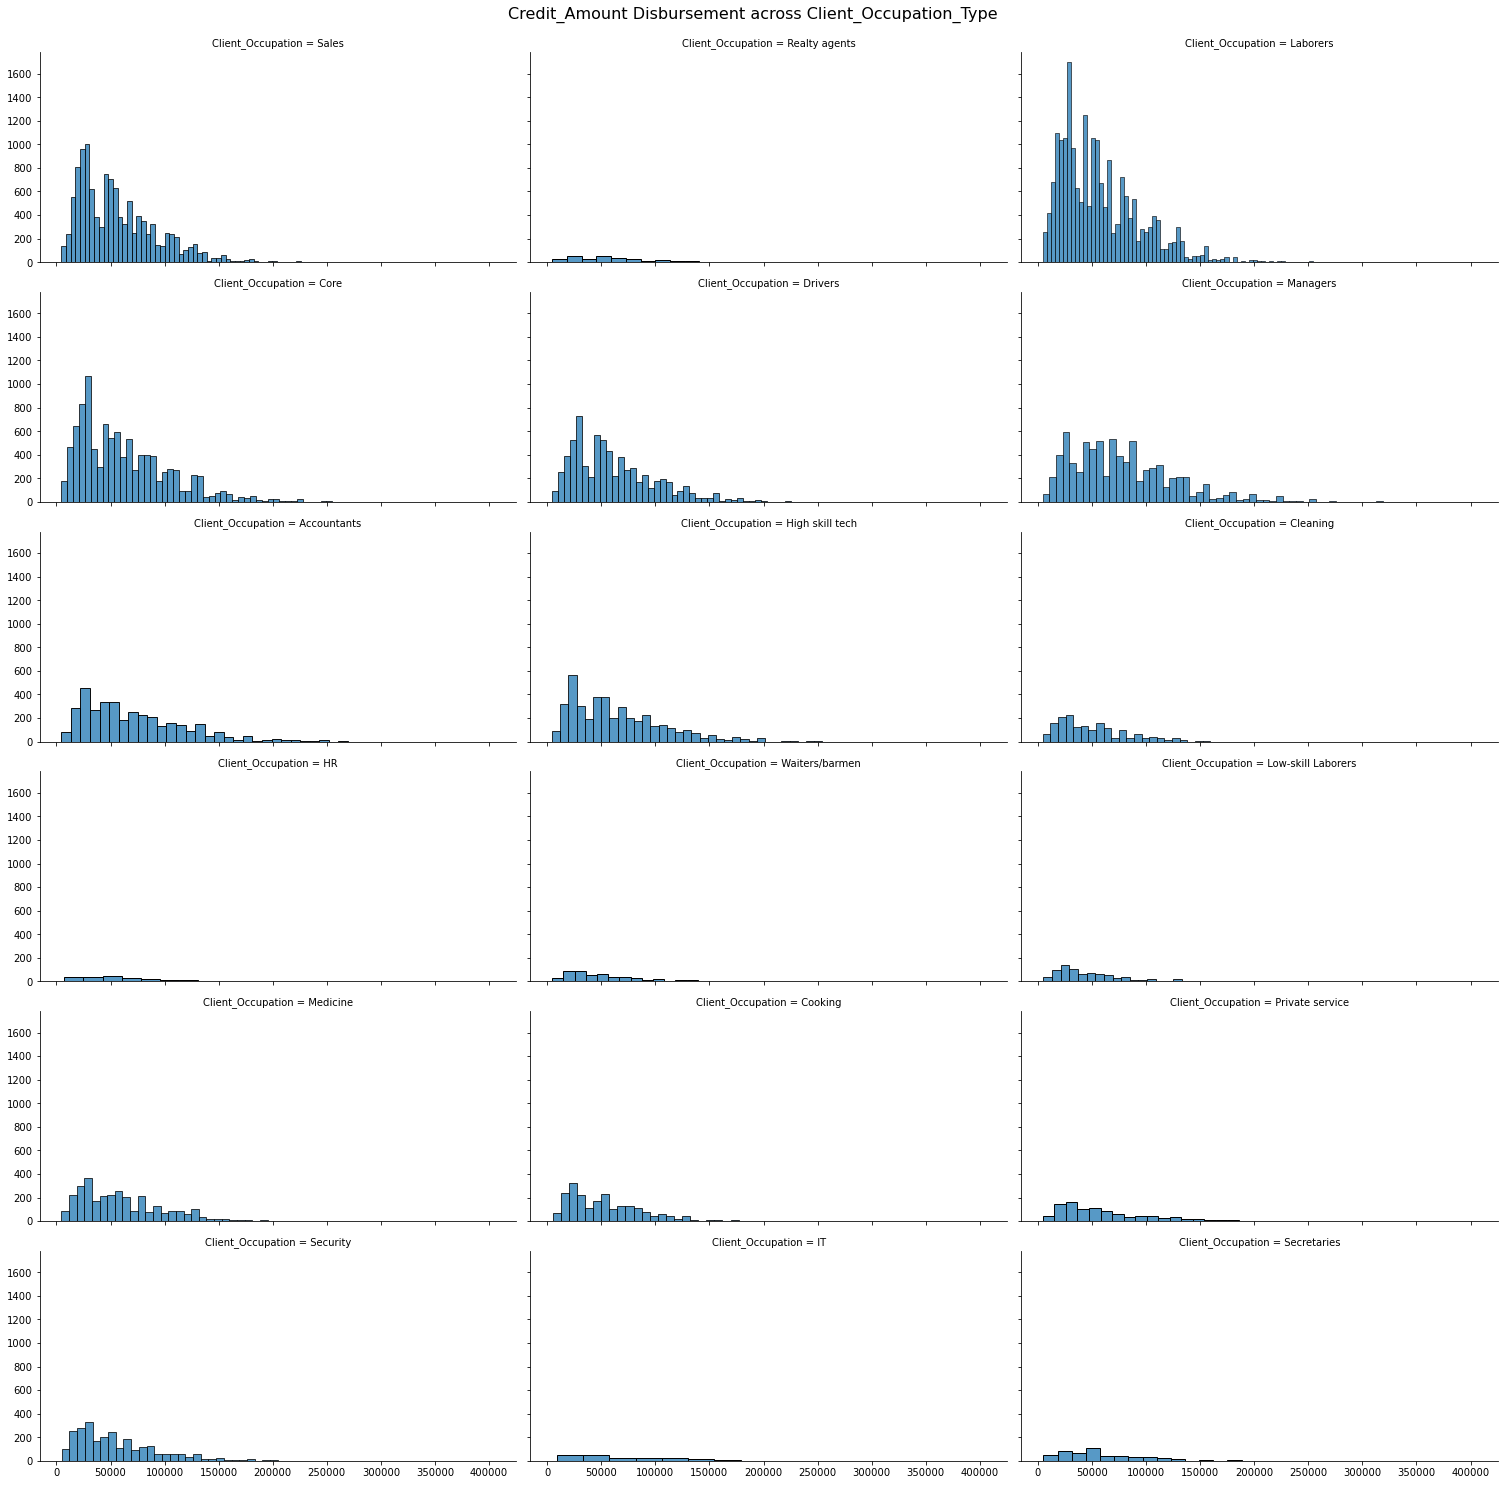

In [140]:
plt.figure(figsize=(5,15))

g = sns.FacetGrid(train, col="Client_Occupation", size=3.5, aspect=2, col_wrap=3)
g.map_dataframe(sns.histplot, x="Credit_Amount")

g.fig.subplots_adjust(top=0.95) # adjust the Figure in g
g.fig.suptitle('Credit_Amount Disbursement across Client_Occupation_Type', fontsize=16)

In [143]:
train.groupby("Client_Occupation", as_index=False)['Credit_Amount'].count().sort_values('Credit_Amount', ascending=False)

,Client_Occupation,Credit_Amount
8,Laborers,20425
14,Sales,11763
3,Core,10310
10,Managers,7857
4,Drivers,6932
6,High skill tech,4195
0,Accountants,3640
11,Medicine,3067
16,Security,2614
2,Cooking,2170


In [162]:
train.groupby("Type_Organization", as_index=False)['Credit_Amount'].count().sort_values('Credit_Amount', ascending=False).head()

,Type_Organization,Credit_Amount
5,Business Entity Type 3,25504
42,Self-employed,14273
33,Other,6087
30,Medicine,4190
4,Business Entity Type 2,4016


- Most of the Credit_Amount was disbursed to the Laborers, Sales and Core occupation people.
- HR, IT individuals have low loan disbural rate.
- Type_Organization is not clearly available in the dataset

In [160]:
train.groupby(["Client_Marital_Status", "Client_Family_Members"])['Credit_Amount'].count().unstack()

Client_Family_Members,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,13.0,14.0,15.0,16.0
Client_Marital_Status,,,,,,,,,,,,,,,
D,5151.0,1559.0,443.0,50.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
M,NaN,54226.0,18446.0,8937.0,1252.0,142.0,28.0,10.0,4.0,2.0,3.0,1.0,1.0,NaN,2.0
S,14167.0,1996.0,315.0,34.0,8.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
W,5366.0,326.0,78.0,11.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Mostly married clients have 2-4 family members i.e. 0-2 childrens.
- Divorced clients have 0-3 childrens mostly.

## Target(Default) Analysis

In [170]:
train.value_counts('Default', normalize=True)

Default
0    0.919208
1    0.080792
dtype: float64

In [174]:
train.groupby('Default', as_index=False)['Credit_Amount'].sum()

,Default,Credit_Amount
0,0,6.564389e+09
1,1,5.342467e+08


<AxesSubplot:xlabel='Default', ylabel='count'>

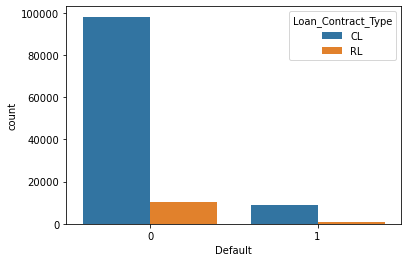

In [182]:
sns.countplot(data=train, x="Default", hue="Loan_Contract_Type")

In [195]:
(train.groupby(['Client_Gender', 'Loan_Contract_Type'])
        .Default.value_counts(normalize=True).mul(100).round(1)
        .rename('row_percent').reset_index(2))

Default  row_percent
Client_Gender Loan_Contract_Type                      
Female        CL                        0         89.6
              CL                        1         10.4
              RL                        0         94.1
              RL                        1          5.9
Male          CL                        0         92.8
              CL                        1          7.2
              RL                        0         94.3
              RL                        1          5.7

In [201]:
(pd.crosstab(index=train['Default'],
             columns=train['Client_Gender'],
             values=train['Client_Income'],
             aggfunc='median'))

Client_Gender,Female,Male
Default,,
0,18000.0,13500.0
1,15750.0,13500.0


**Key Inference**

- 8% total default cases
- $0.5bn defaulted Credit_Amount, out of total $7bn disbursement.
- Females default more than men across Cash Loans (10.4% vs 7.2%)
- **Median Client_Income across genders** - Females have higher median income w.r.t Males in default condition.

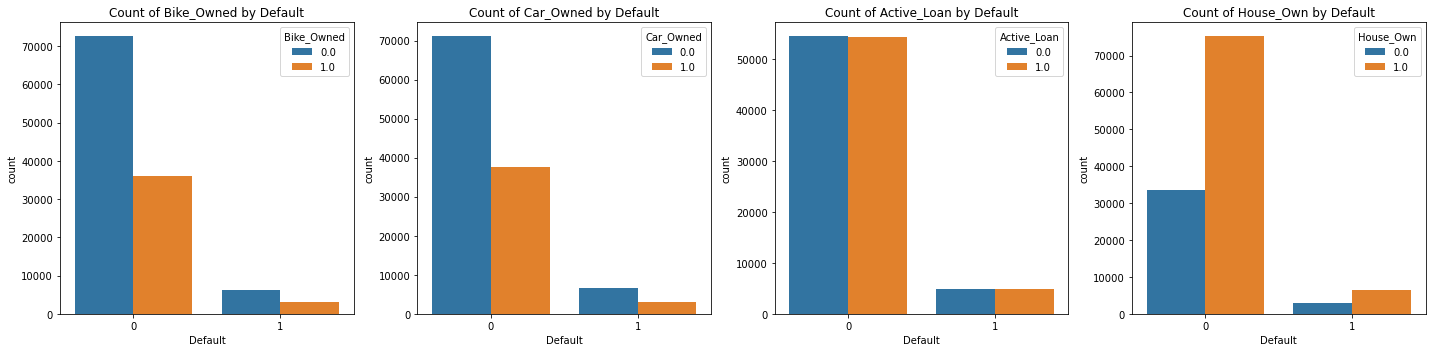

In [209]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 4, figsize=(20,5))

# Plot on the first subplot
sns.countplot(data=train, x="Default", hue="Bike_Owned", ax=ax[0])
ax[0].set_title('Count of Bike_Owned by Default')

# Plot on the second subplot
sns.countplot(data=train, x="Default", hue="Car_Owned", ax=ax[1])
ax[1].set_title('Count of Car_Owned by Default')

# Plot on the second subplot
sns.countplot(data=train, x="Default", hue="Active_Loan", ax=ax[2])
ax[2].set_title('Count of Active_Loan by Default')

# Plot on the second subplot
sns.countplot(data=train, x="Default", hue="House_Own", ax=ax[3])
ax[3].set_title('Count of House_Own by Default')

fig.suptitle("Default Analysis based on Client Holdings", y=0.98, fontsize=18)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

**Key Inference**

- Most defaulters own any of the Car, bike, house and has an active loan. 

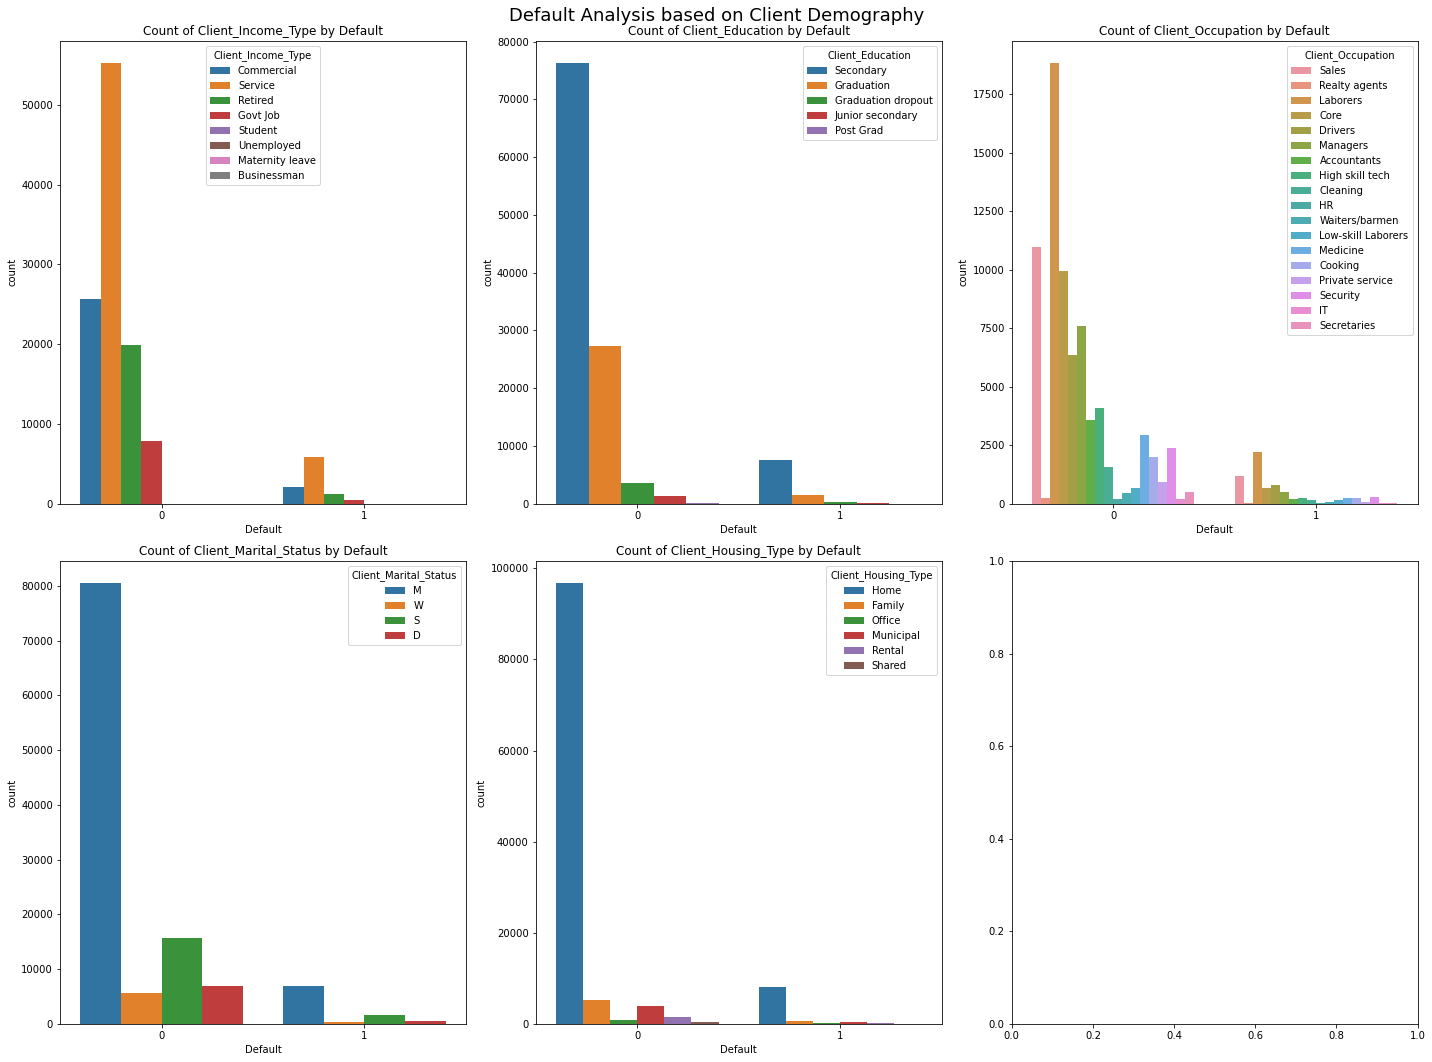

In [216]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(2, 3, figsize=(20,15))

# Plot on the first subplot
sns.countplot(data=train, x="Default", hue="Client_Income_Type", ax=ax[0,0])
ax[0,0].set_title('Count of Client_Income_Type by Default')

# Plot on the second subplot
sns.countplot(data=train, x="Default", hue="Client_Education", ax=ax[0,1])
ax[0,1].set_title('Count of Client_Education by Default')

# Plot on the third subplot
sns.countplot(data=train, x="Default", hue="Client_Occupation", ax=ax[0,2])
ax[0,2].set_title('Count of Client_Occupation by Default')

# Plot on the fourth subplot
sns.countplot(data=train, x="Default", hue="Client_Marital_Status", ax=ax[1,0])
ax[1,0].set_title('Count of Client_Marital_Status by Default')

# Plot on the five subplot
sns.countplot(data=train, x="Default", hue="Client_Housing_Type", ax=ax[1,1])
ax[1,1].set_title('Count of Client_Housing_Type by Default')

# # Plot on the six subplot
# sns.countplot(data=train, x="Default", hue="Type_Organization", ax=ax[1,2])
# ax[1,2].set_title('Count of Type_Organization by Default')

fig.suptitle("Default Analysis based on Client Demography", y=0.98, fontsize=18)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

**Key Inference**

- Service based, Secondary educated, Labourers and Married ones are the most defaulters.

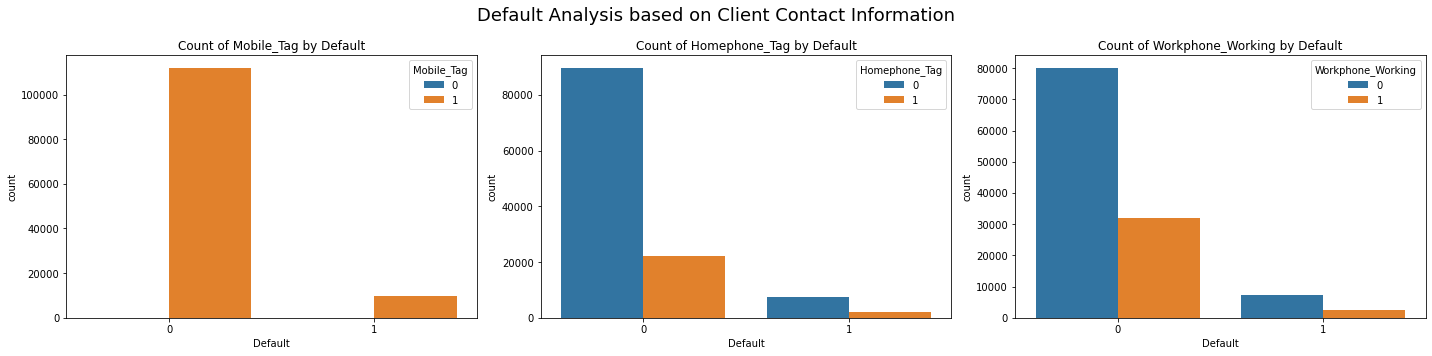

In [232]:
# Create subplots with 1 rows and 2 columns
fig, ax = plt.subplots(1, 3, figsize=(20,5))

# Plot on the first subplot
sns.countplot(data=train, x="Default", hue="Mobile_Tag", ax=ax[0])
ax[0].set_title('Count of Mobile_Tag by Default')

# Plot on the second subplot
sns.countplot(data=train, x="Default", hue="Homephone_Tag", ax=ax[1])
ax[1].set_title('Count of Homephone_Tag by Default')

# Plot on the three subplot
sns.countplot(data=train, x="Default", hue="Workphone_Working", ax=ax[2])
ax[2].set_title('Count of Workphone_Working by Default')

fig.suptitle("Default Analysis based on Client Contact Information", y=0.98, fontsize=18)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

- Mobile phones is available for all clients.
- Home and workphones phones are available for some of them.

In [222]:
(train.groupby(['Default'])
        .agg({'Social_Circle_Default':['median', 'mean']}))

Social_Circle_Default          
                       median      mean
Default                                
0                      0.0902  0.118391
1                      0.0825  0.104546

- ~8-10% of defaulters have someone in their social circle who defaulted.

## Bank Analysis

Text(0.5, 1.0, 'Time & Hour at which Bank Processes Credit')

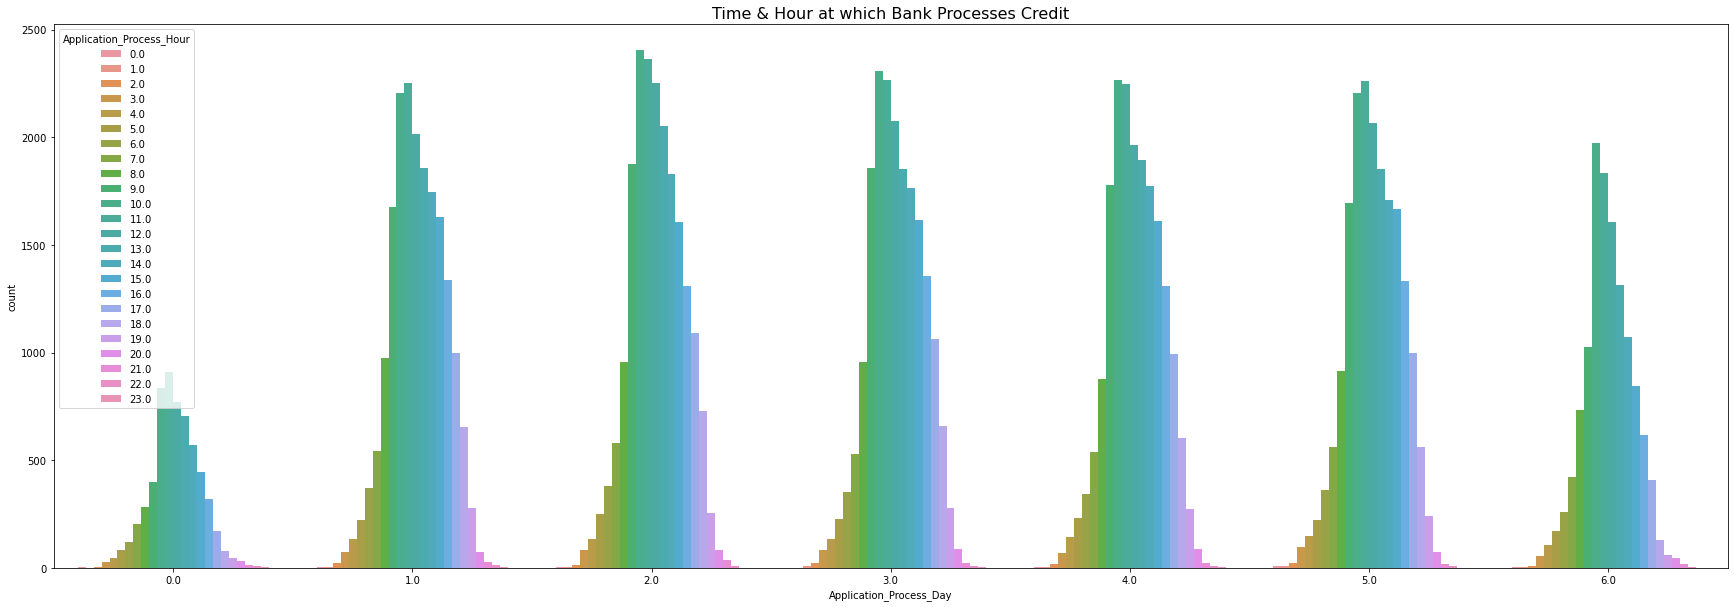

In [231]:
plt.figure(figsize=(30,10))

# Plot on the first subplot
sns.countplot(data=train, x="Application_Process_Day", hue="Application_Process_Hour")
plt.title('Time & Hour at which Bank Processes Credit', fontsize=16)

**Key Inference**

- Bank processes most credit from Monday to Friday between 9am-3pm hours. 

## Numerical Features Analysis

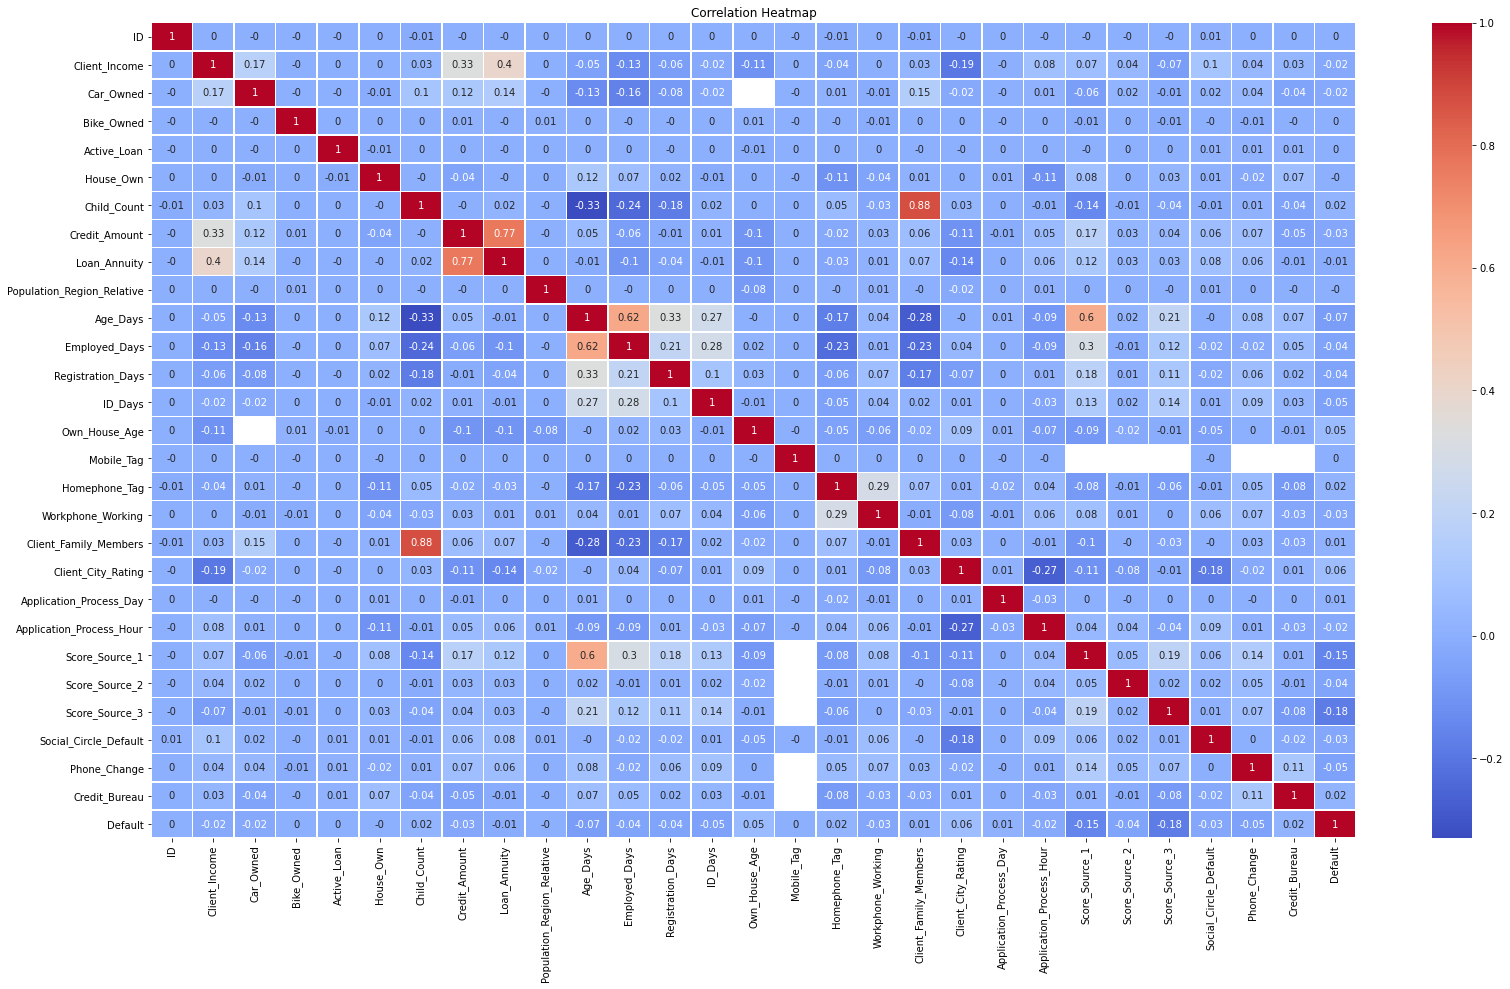

In [247]:
# Calculate correlation matrix
correlation_matrix = train.corr().round(2)

# Create the correlation heatmap
plt.figure(figsize=(27, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Key Inference**

- There is very weak correlations among most of the features.
- Only Client_Family_Members and Child_Count has Strong correlation, Age_days and Score_source1 has mild correlation.

# Feature Engineering

- For categorical features, we will do label encoding. This will not increase the dimensionality space and works well with tree based models
- Also, there are are some irregularities in test dataset, so we need to fix it.

In [48]:
test['Client_Education'] = np.where(test['Client_Education']=='junior secondary', 'Junior secondary', test['Client_Education'])
test['Client_Marital_Status'] = np.where(test['Client_Marital_Status']=='Unknown', np.nan, test['Client_Marital_Status'])
test['Score_Source_2'] = np.where(test['Score_Source_2']=='#', np.nan, test['Score_Source_2'])
test['Score_Source_2'] = test['Score_Source_2'].astype('float')

In [49]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # Train on the training data
        le.fit(train[col])
        # Transform both training and testing data
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
        # Keep track of how many columns were label encoded
        le_count += 1
            
print('%d columns were label encoded.' % le_count)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

11 columns were label encoded.
Training Features shape:  (121856, 40)
Testing Features shape:  (80900, 39)


In [60]:
# train.to_parquet('./data/processed/training_data_encoded.parquet', index=False)
# test.to_parquet('./data/processed/test_data_encoded.parquet', index=False)